In [ ]:
import requests
from lib.authenticate import bearer
import pandas as pd
from lib.epoch_time import epoch_to_datetime, date_to_epoch
import matplotlib.pyplot as plt
import numpy as np
import tulipy as ti
import urllib.parse

[INFO]: Access token last updated: 2025-07-07 10:03:17 (expires in 659 seconds)
[INFO]: Refresh token last updated: 2025-07-06 17:32:05 (expires in 7 days)
[INFO]: Linked Accounts: [{'accountNumber': '59602680', 'hashValue': '3F4575C1F03A0A2DFE55356F0872FA3956469780FEDD669DFC5A62884E311A8C'}]
[INFO]: Initialization Complete


In [2]:
# Market Data API
market_url = "https://api.schwabapi.com/marketdata/v1/"

In [3]:
# Symbol formatting
def format_symbol (symbol_input):
    symbol = symbol_input.strip().upper()
    if symbol.startswith("/"):
        return urllib.parse.quote(symbol)
    return symbol

In [4]:
# Price History
def get_price_history(symbol): # symbol comes from user input in main()
    endpoint = "pricehistory"

    symbol = format_symbol(symbol)

    period_type =  input("Period type (day, month, year, ytd): ")
    period = 0
    freq_type = ""
    match period_type:
        case "day" | "d":
            period_type = "day" # set period type to full name if abbreviation is used
            period_options = "(1, 2, 3, 4, 5, 10)"
            freq_type = "minute" # no freq_type_options because frequency is always "minute"
        case "month" | "m":
            period_type = "month"
            period_options = "(1, 2, 3, 6)"
            freq_type_options = "(daily, weekly)"
        case "year" | "y":
            period_type = "year"
            period_options = "(1, 2, 3, 5, 10, 15, 20)"
            freq_type_options = "(daily, weekly, monthly)"
        case "ytd":
            # period_type is always ytd. no full name option
            period = 1 # no period_options becase period is always 1
            freq_type_options ="(daily, weekly)"
        case _:
            print("Invalid period type.")

    if period != 1: # for ytd period is set to 1 previously. all other options, period is selected from input
        period = input(f"Period {period_options}: ")

    if freq_type != "minute": # for day period freq_type is set to minute previously. all other options, freq_type is selected from input
        freq_type = input(f"Frequency type {freq_type_options}: ")
        frequency = 1 # all types except minute must have frequency = 1
    elif freq_type == "minute":
        freq_options = "min: (1, 5, 10, 15, 30)"
        frequency = input(f"Frequency {freq_options}: ")

    match freq_type:
        case "daily" | "d": # set freq_type to full name if abbreviation is used
            freq_type = "daily"
        case "weekly" | "w":
            freq_type = "weekly"
        case "monthly" | "m":
            freq_type = "monthly"

    try:
        start_date = date_to_epoch(input("Start date (yyyymmdd): ")) # If not specified, will be (endDate - period) excluding weekends and holidays
    except:
        start_date = ""
    try:
        end_date = date_to_epoch(input("End date (yyyymmdd): ")) # If not specified, will default to market close of previous business day
    except:
        end_date = ""


    extended_hours = input("Extended hours (true/false): ") # show extended hours data (true/false). Defaults to false.
    match extended_hours:
        case "true" | "t":
            extended_hours = "true"
        case "false" | "f":
            extended_hours = "false"
        case _:
            extended_hours = "false"
    
    show_previous_close = "true" # show previous close price (true/false)
    # symbol = "SPY"
    # period_type = "day"
    # period = 1
    # freq_type = "minute"
    # frequency = 5
    # start_date = ""
    # end_date = ""
    # extended_hours = "false"
    # show_previous_close = "true"
    params = {
        "symbol": symbol,
        "periodType": period_type,
        "period": period,
        "frequencyType": freq_type,
        "frequency": frequency,
        "startDate": start_date,
        "endDate": end_date,
        "needExtendedHoursData": extended_hours,
        "needPreviousClose": show_previous_close
    }

    # Request data
    response = requests.get(f"{market_url}{endpoint}", params=params,
        headers={f"Authorization": f"Bearer {bearer}"})

    # Check the status code of the response
    if response.status_code == 200:
        returned_data = response.json()  # Parse the response JSON data
        if 'candles' in returned_data:
            # Convert epoch time to date string
            for candle in returned_data['candles']:
                epoch_time_ms = candle['datetime']
                candle['datetime'] = epoch_to_datetime(epoch_time_ms)
            # Create DataFrame from the data
            df = pd.DataFrame(returned_data['candles'])
            return df
        else:
            print("No candle data found in the response.")
    else:
        print(f"Failed to retrieve data: {response.status_code}")

In [5]:
# Main block
def main():
    symbol = input("Symbol:" )
    price_df = get_price_history(symbol)

    # Plot price data
    if price_df is not None:
        # plt.figure(figsize=(12, 6))
        # plt.plot(price_df["datetime"], price_df["close"])
        # plt.title(symbol.upper())
        # plt.grid(True)
        # plt.xticks(rotation=45)
        # #plt.tight_layout()
        # plt.show()

        fig, ax = plt.subplots(figsize=(12,6))

        ax.plot(price_df.index, price_df['close'])  # using the index of each data point instead of the date since we don't want off hours on the time axis

        # Set ticks at indices corresponding to first timestamp each day
        price_df['date'] = price_df['datetime'].dt.date
        unique_dates = price_df['date'].drop_duplicates()
        first_indices = price_df.groupby('date').head(1).index

        ax.set_xticks(first_indices)
        ax.set_xticklabels(unique_dates, rotation=45)

        plt.grid(True)
        plt.tight_layout()
        plt.show()


        # print(price)
        # print(price.to_numpy())

        # sma = ti.sma(price.to_numpy(), period=5)
        # print(sma)

    # Show dataframe
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(price_df)

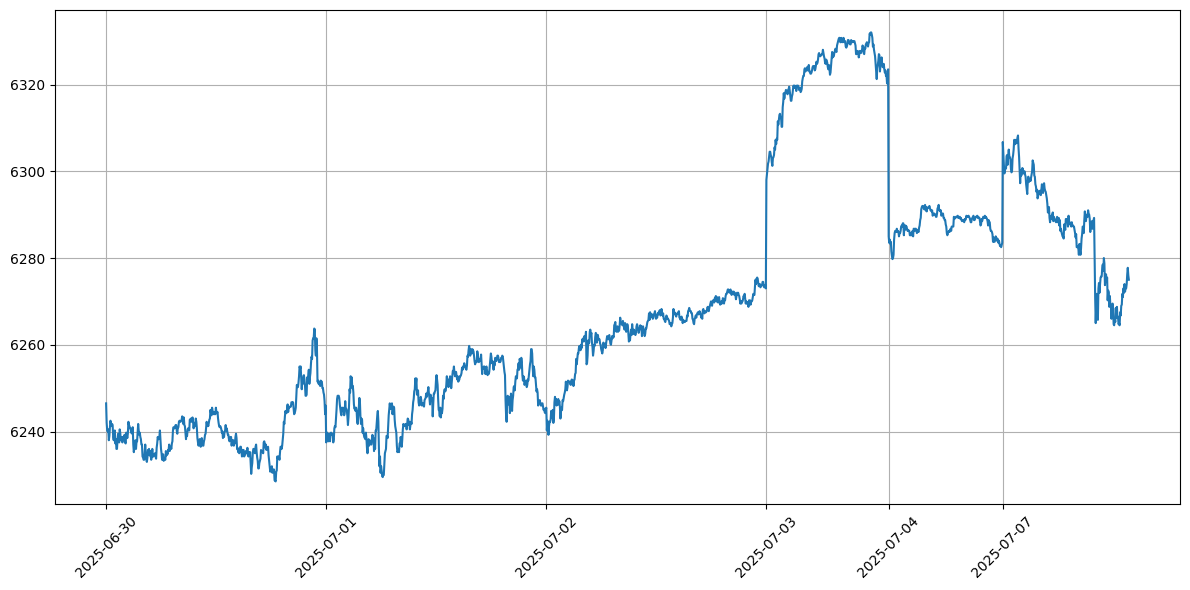

         open     high      low    close  volume            datetime        date
0     6248.00  6249.00  6243.75  6246.50    7139 2025-06-30 06:30:00  2025-06-30
1     6246.50  6247.00  6241.75  6242.00    4893 2025-06-30 06:31:00  2025-06-30
2     6241.75  6243.25  6240.00  6240.25    5409 2025-06-30 06:32:00  2025-06-30
3     6240.00  6240.75  6238.75  6240.00    4274 2025-06-30 06:33:00  2025-06-30
4     6240.00  6241.75  6238.50  6240.50    4586 2025-06-30 06:34:00  2025-06-30
5     6240.50  6240.75  6237.75  6238.00    3068 2025-06-30 06:35:00  2025-06-30
6     6238.25  6239.25  6236.00  6239.00    5564 2025-06-30 06:36:00  2025-06-30
7     6238.75  6242.00  6238.00  6241.00    4638 2025-06-30 06:37:00  2025-06-30
8     6241.25  6243.00  6241.00  6242.50    2944 2025-06-30 06:38:00  2025-06-30
9     6242.50  6243.50  6241.50  6241.75    1938 2025-06-30 06:39:00  2025-06-30
10    6241.75  6242.00  6239.75  6241.25    2301 2025-06-30 06:40:00  2025-06-30
11    6241.00  6241.75  6240

In [6]:
if __name__ == "__main__":
    main()